In [1]:
import numpy as np

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms.functional as TF

In [3]:
from unet import UNet
from perses.dnet import Net as Perses
from inundatio import get_houses, pad_bbox

In [4]:
from src.vis import draw_bbox, add_padding
from src.data import crop, combine_maps

In [5]:
THEIA_MODEL = './theia/model/theia.pth'
PERSES_MODEL = './perses/model/perses.pt'

In [6]:
# PRE = './images/mexico-earthquake_00000169_pre_disaster.png'
# POST = './images/mexico-earthquake_00000169_post_disaster.png'
PRE = './images/hurricane-florence_00000087_post_disaster.png'
POST = './images/hurricane-florence_00000087_pre_disaster.png'
# PRE = './images/hurricane-florence_00000384_pre_disaster.png'
# POST = './images/hurricane-florence_00000384_post_disaster.png'

In [7]:
before = Image.open(PRE)
after = Image.open(POST)

In [8]:
assert before.size == after.size

In [9]:
SIZE = before.size[0]

In [10]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device "%s" for calculation' % dev)

Using device "cuda" for calculation


In [11]:
theia = UNet(in_channels=3, out_channels=1, padding=True)
theia.load_state_dict(torch.load(THEIA_MODEL))
theia.eval()
theia = theia.to(dev)

In [12]:
perses = Perses()
perses.load_state_dict(torch.load(PERSES_MODEL))
perses.eval()
perses = perses.to(dev)

In [13]:
before = crop(before)

In [14]:
seg_maps = []
for img in before:
    seg_map = theia(img.unsqueeze(0).to(dev))
    seg_map = torch.sigmoid(seg_map).squeeze().detach().to('cpu')
    
    seg_map[seg_map<0.10] = 0
    seg_map[seg_map>0] = 1
    
    seg_maps.append(seg_map)

In [15]:
seg_map = combine_maps(seg_maps).squeeze().detach().numpy()

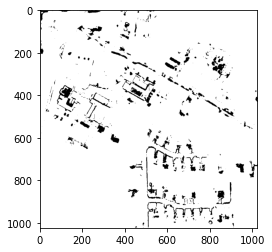

In [16]:
plt.imshow(seg_map, cmap='gray_r')

In [17]:
coords = get_houses(seg_map)
coords = [add_padding(box, clip_max=SIZE) for box in coords]

# print(coords)

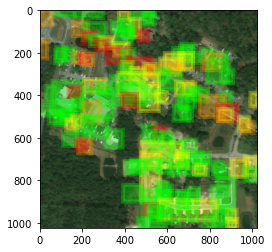

In [18]:
fig, ax = plt.subplots(1)
# img = Image.open(POST)
# img = TF.center_crop(img, 512)

ax.imshow(after)

for bbox in coords:
    bbox_image = after.crop((bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]))
    
    x = TF.resize(bbox_image, (75, 75))
    x = TF.to_tensor(x)
    
    damage = perses(x.to(dev).unsqueeze(0))
    damage = torch.sigmoid(damage).detach().squeeze().to('cpu')
    
    draw_bbox(ax, bbox, damage)